# Face Recognition (EE5907 CA2)

## READEME

### 1. Overview
This project implements a pipeline for face recognition using various machine learning techniques: Principal Component Analysis (PCA), Linear Discriminant Analysis (LDA), Support Vector Machines (SVM), and Convolutional Neural Networks (CNN). The dataset includes the CMU PIE dataset and self-captured face images.<br>
The implementation follows these main steps:
1. Data Preprocessing.
2. Feature Extraction with PCA and LDA.
3. Classification with KNN and SVM.
4. Deep Learning with CNN.

### 2. Dataset
1. **CMU PIE Dataset**: Contains images from 68 different individuals. We selected 25 subjects and split the images into 70% training and 30% testing.
2. **Self-captured Photos**: 10 grayscale selfies resized to 32×32 pixels, with 7 used for training and 3 for testing, labeled as '0'.

### 3. Project Structure
* **PIE/**: The folder of original CMU PIE images.<br>
* **PROCESSED/train/**: Training images organized by folder (label corresponds to folder name).<br>
* **PROCESSED/test/**: Testing images organized similarly.<br>
* **A0295779Y_Xu_Yimian_CA2(EE5907).ipynb**: Jupyter Notebook containing the entire pipeline code, README and Report.<br>
* **A0295779Y_Xu_Yimian_CA2(EE5907).pdf**: The exported PDF file of the *.ipynb file.<br>

### 4. Installation
#### Prerequisites
* Python 3.10+
* Required libraries:
  * numpy
  * scikit-learn
  * matplotlib
  * torch
  * torchvision
  * mtcnn
  * libsvm
#### Environment Setup
```bash
conda create -n ee5907_ca2 python=3.10
conda activate ee5907_ca2
pip install numpy scikit-learn matplotlib torch torchvision mtcnn libsvm-official
```

### 5. Steps and Results
1. Data Preprocessing
* The dataset was processed to ensure uniform size (32×32 pixels) and grayscale format.
* Self-captured photos were enhanced using CLAHE to improve contrast.
2. PCA: Dimensionality Reduction and Visualization
* **Dimensionality** Reduction: PCA reduced the 1024-dimensional image vectors to 2, 3, 40, 80, and 200 dimensions.
* **Visualization**: 2D and 3D scatter plots were created to visualize the data.
* **Results**: Test and show the accuracy.
3. LDA: Dimensionality Reduction and Classification
* **Dimensionality** Reduction: LDA reduced dimensions to 2, 3, and 9.
* **Visualization**: Scatter plots for training and testing data in 2D and 3D.
* **Results**: Test and show the accuracy.
4. SVM: Classification
* **Kernel**: Linear kernel using LIBSVM.
* **Data**: Tested with raw data and PCA-reduced data.
* **Results**:
  * PCA 80 components: 98.75%.
  * PCA 200 components: 99.37%.
5. CNN: Deep Learning for Classification
* **Architecture**:
  * Two convolutional layers with 20 and 50 filters, followed by max pooling.
  * Two fully connected layers with 500 and 26 outputs.
* **Training**:
  * 10 epochs using the Adam optimizer.
* **Results**:
  * Overall Accuracy: 98.98%.
  * PIE Accuracy: 98.98%.
  * Self-captured Accuracy: 100.00%.
  
### 6. Usage
Running the Notebook:
1. Ensure the environment is activated: conda activate ee5907_ca2.
2. Launch Jupyter Notebook: jupyter notebook.
3. Open A0295779Y_Xu_Yimian_CA2(EE5907).ipynb.
4. Adjust paths and parameters and run the cells sequentially.

Key Functions:
* **pca_from_scratch**: PCA implementation using SVD.
* **apply_lda**: LDA implementation from scratch.
* **run_svm**: SVM classification using LIBSVM.
* **CNN**: PyTorch CNN model for face recognition.

## PART 1: PCA

### Step 1: process the dataset

In [ ]:
# 1. split the PIE dataset to training and testing dataset
# Notes: The prepares data folders have been zipped the submission zip file, there is no need to run again. (If you want, of course you can.)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # do not use GPU
import random
import shutil
from sklearn.model_selection import train_test_split

DATASET_DIR = "./PIE"
OUTPUT_DIR = "./PROCESSED"
TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
TEST_DIR = os.path.join(OUTPUT_DIR, "test")

NUM_SELECTED_FACES = 25
TRAIN_RATIO =0.70001

def split_images(folder_path, train_dir, test_dir):
    all_images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    train_images, test_images = train_test_split(all_images, train_size=TRAIN_RATIO, random_state=42)
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), train_dir)
    for image in test_images:
        shutil.copy(os.path.join(folder_path, image), test_dir)

def select_faces(dataset_dir, face_sel_num, test_dir, train_dir):
    # randomly select 25 faces
    all_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
    selected_folders = random.sample(all_folders, face_sel_num)
    print(f"Selected Folders: {selected_folders}")

    # Ensure output directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for folder in selected_folders:
        folder_path = os.path.join(dataset_dir, folder)

        # Create subdirectories for each face in training and testing folders
        train_subdir = os.path.join(train_dir, folder)
        test_subdir = os.path.join(test_dir, folder)

        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        # Split images into training and testing sets
        split_images(folder_path, train_subdir, test_subdir)

    print("Dataset processing complete!")

# usage example:
# select_faces(DATASET_DIR,NUM_SELECTED_FACES,TEST_DIR,TRAIN_DIR)

In [ ]:
# 2. Process my selfie dataset
# Notes: The prepares data folders have been zipped in the submission zip file, there is no need to run again.
from mtcnn import MTCNN
import cv2
import os

def adjust_face_box(face_box, shrink_factor=0.2):
    x, y, w, h = face_box
    dx = int(w * shrink_factor / 2)
    dy = int(h * shrink_factor / 2)
    x_new = x + dx
    y_new = y + dy
    w_new = w - 2 * dx
    h_new = h - 2 * dy
    return x_new, y_new, w_new, h_new

def detect_face_mtcnn(input_folder, output_folder, target_size=(32, 32), fixed_ratio=1.0):
    # initialize MTCNN detector
    detector = MTCNN()

    # Traverse through folders
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        
        # skip non-image file
        if not (filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg")):
            print(f"Skipping non-image file: {filename}")
            continue
        
        # read images
        image = cv2.imread(input_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # detect faces
        results = detector.detect_faces(image_rgb)

        for i, result in enumerate(results):
            x, y, width, height = result['box']
            confidence = result['confidence']
            if confidence > 0.5:  # confidence filtering
                # adjust the bounding box to a fixed scale
                if fixed_ratio == 1.0:  # square
                    max_side = max(width, height)
                    x = int(x + width / 2 - max_side / 2)
                    y = int(y + height / 2 - max_side / 2)
                    width = height = max_side
                else:  # other ratio
                    if width / height > fixed_ratio:
                        new_height = int(width / fixed_ratio)
                        y = int(y - (new_height - height) / 2)
                        height = new_height
                    else:
                        new_width = int(height * fixed_ratio)
                        x = int(x - (new_width - width) / 2)
                        width = new_width

                # make sure that the bounding box does not extend beyond the image
                x = max(0, x)
                y = max(0, y)
                width = min(image.shape[1] - x, width)
                height = min(image.shape[0] - y, height)

                # shrink the detection area to reduce unwanted background information
                x,y, width, height = adjust_face_box((x, y, width, height), shrink_factor=0.2)

                # crop
                face = image[y:y+height, x:x+width]

                # enhance image and resize
                gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))
                enhanced_face = clahe.apply(gray_face)
                face_resized = cv2.resize(enhanced_face, target_size, interpolation=cv2.INTER_LANCZOS4)
                
                # save as jpg format
                output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_face_{i}.jpg")
                cv2.imwrite(output_path, face_resized)
                print(f"Face {i} from {filename} saved to {output_path}")

# usage example:
# input_folder = "./myface"         # input path
# output_folder = "./myface_out"    # output path
# detect_face_mtcnn(input_folder, output_folder)

### Step 2: Data Preparation

The raw image size is 32 $\times$ 32, first we flatten it into a 1024-dimensional vector, and then we combine 500 images form the CMU PIE dataset and my own photos, finally, we need to standardize the vectors(mean-centering and scaling).<br>

In [ ]:
# 1. select 500 images randomly 
import numpy as np
from skimage.io import imread
from skimage.transform import resize

IMAGE_SIZE = (32, 32)  # Picture size
SAMPLE_SIZE = 500      # Sample number

def sample_images(data_dir, sample_size=SAMPLE_SIZE, image_size=IMAGE_SIZE):
    # get all the paths and labels
    all_image_paths = []
    all_labels = []
    
    for folder in os.listdir(data_dir):
        if not isinstance(folder, str):
            print(f"Skipping non-str folder: {folder}")
            continue
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if file.endswith(('.jpg', '.png', '.jpeg')):
                all_image_paths.append(os.path.join(folder_path, file))
                all_labels.append(folder)

    # choose 500 pictures as training data ramdonly
    sampled_indices = random.sample(range(len(all_image_paths)), sample_size)
    sampled_paths = [all_image_paths[i] for i in sampled_indices]
    sampled_labels = [all_labels[i] for i in sampled_indices]

    # process pictures
    sampled_images = []
    for path in sampled_paths:
        img = imread(path, as_gray=True)  # gray scale
        img_resized = resize(img, image_size).flatten()  # flatten as 1024-d vectors
        sampled_images.append(img_resized)

    return np.array(sampled_images), np.array(sampled_labels)


# load test data
def load_test_data(test_dir):
    test_images = []
    test_labels = []
    
    for folder_name in sorted(os.listdir(test_dir)):
        if not isinstance(folder_name, str):
            print(f"Skipping non-str folder: {folder_name}")
            continue
        folder_path = os.path.join(test_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue
        for img_name in os.listdir(folder_path):
            if img_name.endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(folder_path, img_name)
                img = imread(img_path, as_gray=True)  # gray scale
                img_resized = img.flatten() #flatten image
                test_images.append(img_resized)
                test_labels.append(folder_name)  # save labels
    
    return np.array(test_images), np.array(test_labels)

# prepare the training and testing data
train_images, train_labels = sample_images(TRAIN_DIR)
test_images, test_labels = load_test_data(TEST_DIR)

print(f"Sampled {len(train_images)} training images.")
print(f"Unique labels: {set(train_labels)}")

print(f" {len(test_images)} testing images.")
print(f"Unique labels: {set(test_labels)}")

Sampled 500 training images.
Unique labels: {'1', '66', '2', '18', '7', '15', '33', '16', '0', '23', '26', '6', '19', '31', '14', '54', '38', '20', '34', '37', '39', '10', '32', '52', '61', '24'}
 1277 testing images.
Unique labels: {'1', '66', '2', '18', '7', '15', '33', '16', '0', '23', '26', '19', '6', '31', '14', '54', '38', '20', '34', '37', '39', '10', '32', '52', '61', '24'}


### Step 3: PCA dimensionality reduction（Feature Extraction）

In [ ]:
# 1. implement the PCA algorithm and then reduce the dimension of the training image (from 1024 to 2 and 3)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def standardize_data(X):
    # std = np.std(X, axis=0)
    std = 1.0
    mean = np.mean(X, axis=0)  # mean value
    X_centered = (X - mean) / std    # centralization
    return X_centered, mean, std

# PCA (by SVD)
def pca_from_scratch(X, n_components):
    X_centered, mean, std= standardize_data(X)  # data standardization
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)  # SVD decomposition
    V = Vt.T  # V is the eigen vectors: the direction vectors of components
    
    # select first n components
    components = V[:, :n_components]
    # print(f"components:{components}")
    explained_variance = (S**2)[:n_components] / (X_centered.shape[0] - 1)
    eigenvalues = (S**2) / (X_centered.shape[0] - 1)
    # explained variance normalization
    sum_eigenvalue = np.sum(eigenvalues)
    explained_variance_ratio = explained_variance/sum_eigenvalue
    # project data to principal components
    X_projected = np.dot(X_centered, components)
    
    return X_projected, components, explained_variance_ratio, mean, std

# Reduce demensionality to 2-D and 3-D
train_pca_2d, components_2d, var_2d, mean, std = pca_from_scratch(train_images, n_components=2)
train_pca_3d, components_3d, var_3d, _, _ = pca_from_scratch(train_images, n_components=3)
print("Explained variance ratio for 2D PCA:", var_2d)
print("Explained variance ratio for 3D PCA:", var_3d)

# validation using `sklearn`(just for comparing the result)###############################
# PCA: 1024 to 2-D
pca_2d = PCA(n_components=2)
train_pca_2d_valid = pca_2d.fit_transform(train_images)

# PCA: 1024 to 3-D
pca_3d = PCA(n_components=3)
train_pca_3d_valid = pca_3d.fit_transform(train_images)

print("[sklearn] :Explained variance ratio for 2D PCA:", pca_2d.explained_variance_ratio_)
print("[sklearn] :Explained variance ratio for 3D PCA:", pca_3d.explained_variance_ratio_)

Explained variance ratio for 2D PCA: [0.45455652 0.23654167]
Explained variance ratio for 3D PCA: [0.45455652 0.23654167 0.06813989]
[sklearn] :Explained variance ratio for 2D PCA: [0.45455652 0.23654167]
[sklearn] :Explained variance ratio for 3D PCA: [0.45455652 0.23654167 0.06813989]


### Step 4: PCA visualization

<Figure size 640x480 with 0 Axes>

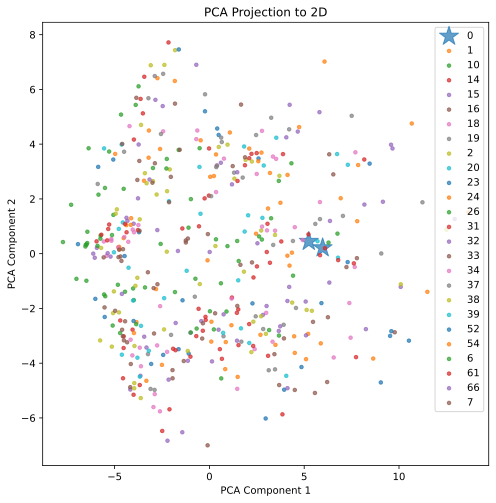

<Figure size 800x800 with 0 Axes>

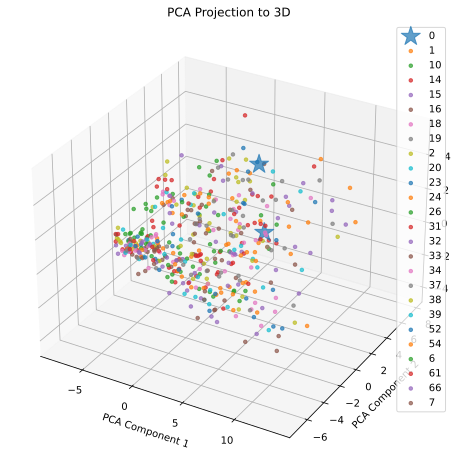

In [ ]:
# 1. (PCA) visualize the 2D and 3D component distribution 
# For better display: figures are displayed as svg
%matplotlib inline
plt.tight_layout()
%config InlineBackend.figure_format = 'svg'

# Visualize Data (this function will be reused in LDA visualization)
def visualize(X_train, y_train, n_components, method="PCA"):
    """
    Visualize transformed data.
    - X_train: dimensionality-reduced training data.
    - y_train: Training labels.
    - n_components: Number of components (2 or 3).
    """
    plt.figure(figsize=(8, 8))
    if n_components == 2:
        for label in np.unique(y_train):
            mask = (y_train == label)
            if(label == '0'):
                Marker='*'
                Size = 400
            else:
                Marker='.'
                Size = 50
            plt.scatter(
                X_train[mask, 0],
                X_train[mask, 1],
                label=f"{label}",
                marker = Marker,
                s = Size,
                alpha=0.7
            )
        plt.title( f"{method} Projection to 2D")
        plt.xlabel(f"{method} Component 1")
        plt.ylabel(f"{method} Component 2")
    elif n_components == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(y_train):
            mask = (y_train == label)
            if(label == '0'):
                Marker='*'
                Size = 400
            else:
                Marker='.'
                Size = 50
            ax.scatter(
                X_train[mask, 0],
                X_train[mask, 1],
                X_train[mask, 2],
                label=f"{label}",
                marker = Marker,
                s = Size,
                alpha=0.7
            )
        ax.set_title( f"{method} Projection to 3D")
        ax.set_xlabel(f"{method} Component 1")
        ax.set_ylabel(f"{method} Component 2")
        ax.set_zlabel(f"{method} Component 3")
    plt.legend()
    plt.show()

visualize(train_pca_2d, train_labels, n_components=2, method="PCA")
visualize(train_pca_3d, train_labels, n_components=3, method="PCA")

#### @ PCA-Based Data Distribution Visualization（1）
##### Results:
* In the 2D scatter plot:
    * Most CMU PIE data points clustered distinctly, representing good variance. Notice that points do not cluster compactly by label, because the PCA method leverage only the raw data without label.
    * Self-captured photos (label 0) are relatively scattered and closer to certain CMU PIE clusters, indicating feature similarity with the PIE subset data.
* In the 3D scatter plot:
	* Clusters are more clearly separated compared to 2D, demonstrating the ability of PCA to capture additional variance in higher dimensions.
* PCA retained 45.5% + 23.7% variance in 2D and 45.5% + 23.7% + 6.8% variance in 3D. This indicates that a significant amount of information is preserved even after dimensionality reduction.
##### Analysis:
* PCA effectively reduced the dimensionality while retaining the variance in the dataset.
* The self-captured photos (label 0) were not perfectly aligned with the CMU PIE clusters, indicating domain differences.
* Increasing dimensions (e.g., 3D) improved visualization and cluster separation.

### Step 5: PCA Eigenfaces Visualization

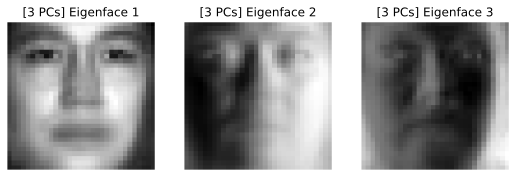

In [7]:
# Component Visualization
eigenfaces = components_3d.T[:3].reshape((-1, 32, 32))
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, ax in enumerate(axes):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"[3 PCs] Eigenface {i+1}")
    ax.axis('off')
plt.show()

#### @ PCA-Based Data Distribution Visualization（2）
The eigen face may not be non-nagative, but the 1st eigen face, corresponding to the basis vector of the maximal variance, contains the most important information for training data. The first eigen face captures the major facial features, the eyes, nose, mouth etc., and the second and third eigen faces may refect the light distribution and some additive details.

### Step 6: Apply PCA and classify using Nearest Neighbor（KNN）
KNN algorithm:
1.	**Calculate Distances:**
For each test sample, compute its Euclidean distance to all training samples.
2.	**Select Nearest Neighbors:**
Sort the distances and select the top k nearest neighbors.
3.	**Vote for Classification:**
Use the labels of the neighbors to perform majority voting and return the most common label.


In [8]:
# Apply PCA with different dimensions
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knn_predict(X_train, y_train, X_test, k=1):
    """
    KNN classifier from scratch
    - X_train: eigen matrix of training dataset (n_samples, n_features)
    - y_train: labels of training dataset (n_samples,)
    - X_test: eigen matrix of test dataset (m_samples, n_features)
    - k: number of the nearest neighbors
    Return:
    - y_pred: predicted label of testing dataset (m_samples,)
    """
    y_pred = []
    for test_sample in X_test:
        # Calculate the Euclidean distance from the current test sample for all training samples
        distances = np.linalg.norm(X_train - test_sample, axis=1)
        
        # find k nearest neighbors
        k_indices = np.argsort(distances)[:k] # sort by distance
        k_labels = y_train[k_indices]  # labels of the k neighbors
        
        # vote and predict
        most_common = Counter(k_labels).most_common(1)[0][0]
        y_pred.append(most_common)
    
    return np.array(y_pred)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Function to classify and calculate accuracy
def classify_and_evaluate(X_train, y_train, X_test, y_test, K=3):
    # sklearn KNN
    # knn = KNeighborsClassifier(n_neighbors=K)  # Nearest neighbor classifier
    # knn.fit(X_train, y_train)  # Train the classifier
    # y_pred = knn.predict(X_test)  # Predict on test data
    
    # implement KNN from scratch
    y_pred = knn_predict(X_train, y_train, X_test, k=K)

    # accuracy of PIE dataset
    pie_indices = (y_test != '0') # PIE data
    pie_accuracy = accuracy(y_test[pie_indices],y_pred[pie_indices])
    # pie_accuracy = accuracy_score(y_test[pie_indices], y_pred[pie_indices])

    # Calculate accuracy for 'my_face' (label 0) separately
    my_face_indices = (y_test == '0') # my data
    my_face_accuracy = accuracy(y_test[my_face_indices], y_pred[my_face_indices])
    # my_face_accuracy = accuracy_score(y_test[my_face_indices], y_pred[my_face_indices])
    
    return pie_accuracy, my_face_accuracy


def pca_transform(X_test, components, mean, std=1):
    # standardization
    X_test_std = (X_test - mean)/std
    # project the test data to the direction of PC
    X_test_pca = np.dot(X_test_std, components)
    return X_test_pca

# Function to apply PCA and return reduced data
def apply_pca(X_train, X_test, n_components):
    # sklearn PCA
    # pca = PCA(n_components=n_components)
    # X_train_pca_valid = pca.fit_transform(X_train)
    # X_test_pca_valid = pca.transform(X_test)  # Transform test data using the same PCA model

    # implement PCA from scratch
    X_train_pca, n_PC, n_var, X_mean, X_std = pca_from_scratch(X_train, n_components = n_components)
    X_test_pca = pca_transform(X_test, n_PC, X_mean, X_std)

    return X_train_pca, X_test_pca, n_PC


# function for pca processing:applying,visualization and evaluation
def run_pca_processing(train_img, train_lbl, test_images, test_labels):
    # Dimensionalities to test
    dimensions = [40, 80, 200]
    # Iterate over the dimensions and evaluate
    for dim in dimensions:
        # Apply PCA
        X_train_pca, X_test_pca, pca_n_PC = apply_pca(train_img, test_images, n_components=dim)

        # Classify and evaluate
        overall_acc, my_face_acc = classify_and_evaluate(X_train_pca, train_lbl, X_test_pca, test_labels, 5)
        
        # print the accuracies:
        print(f"Results for PCA with {dim} components:")
        print(f"- Overall Test Accuracy: {overall_acc*100:.2f}%")
        print(f"- My Face (Label 0) Accuracy: {my_face_acc*100:.2f}%")

In [9]:
# use 500 samples to compute PCA
print(f"\n\n################# Use the 500 training samples for PCA: #################")
run_pca_processing(train_images,train_labels, test_images, test_labels)

print(f"\n\n################# Use ALL the training data for PCA: #################")
# load all the training data
TRAIN_IMG, TRAIN_LABEL = load_test_data(TRAIN_DIR)
run_pca_processing(TRAIN_IMG ,TRAIN_LABEL, test_images, test_labels)



################# Use the 500 training samples for PCA: #################
Results for PCA with 40 components:
- Overall Test Accuracy: 4.32%
- My Face (Label 0) Accuracy: 0.00%
Results for PCA with 80 components:
- Overall Test Accuracy: 4.47%
- My Face (Label 0) Accuracy: 0.00%
Results for PCA with 200 components:
- Overall Test Accuracy: 4.40%
- My Face (Label 0) Accuracy: 0.00%


################# Use ALL the training data for PCA: #################
Results for PCA with 40 components:
- Overall Test Accuracy: 88.85%
- My Face (Label 0) Accuracy: 100.00%
Results for PCA with 80 components:
- Overall Test Accuracy: 92.07%
- My Face (Label 0) Accuracy: 100.00%
Results for PCA with 200 components:
- Overall Test Accuracy: 93.17%
- My Face (Label 0) Accuracy: 100.00%


#### @ PCA Plus Nearest Neighbor Classification Results
##### Results:
* Classification accuracy for different PCA dimensions, for example, in the test using all the training data:
  * 40 dimensions: Overall: 88.85%, My face: 100.00%.
  * 80 dimensions: Overall: 92.07%, My face: 100.00%.
  * 200 dimensions: Overall: 93.17%, My face: 100.00%.
##### Analysis:
* Data Distribution:
  * PCA effectively compressed the high-dimensional data into compact representations. However, lower dimensions (e.g., 40) did not capture enough variance, leading to lower accuracy.
* Accuracy Trends:
  * Accuracy improved consistently as the number of PCA dimensions increased, with 200 dimensions yielding the *best* results.
  * KNN struggles with lower dimensions as it relies on distinguishing neighborhood relationships, which may degrade with *fewer* features.
* Comparison:
  * When we use 500 randomly picked training data to tedt, the self-captured photos achieved lower accuracy than CMU PIE data across all dimensions, likely due to the domain gap (caused by the large difference of training dataset size), and the PIE data also achieved lower acurracy comparing the latter test where we used all training data. As the training data incresing, the accuracy is improved significantly.

## PART 2: LDA

### Step 1: LDA Dimensionality Reduction, Visualizarion and Classification by NN method

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA Fit and Transform from scratch
def apply_lda(X_train, y_train, X_test, n_components):
    """
    Apply LDA to reduce the dimensionality of data.
    - X_train: Training feature matrix.
    - y_train: Training labels.
    - X_test: Test feature matrix.
    - n_components: Number of LDA components.
    Returns:
    - X_train_lda: Reduced training feature matrix.
    - X_test_lda: Reduced test feature matrix.
    - lda: A dictionary containing LDA projection matrix and means for future use.
    """
    n_features = X_train.shape[1]
    class_labels = np.unique(y_train)

    # Compute overall mean
    mean_overall = np.mean(X_train, axis=0)

    # Initialize scatter matrices
    S_W = np.zeros((n_features, n_features))  # Within-class scatter matrix
    S_B = np.zeros((n_features, n_features))  # Between-class scatter matrix
    
    # Compute scatter matrices
    for label in class_labels:
        X_class = X_train[y_train == label]
        mean_class = np.mean(X_class, axis=0)
        
        # Within-class scatter
        S_W += (X_class - mean_class).T @ (X_class - mean_class)
        
        # Between-class scatter
        n_class_samples = X_class.shape[0]
        mean_diff = (mean_class - mean_overall).reshape(-1, 1)
        S_B += n_class_samples * (mean_diff @ mean_diff.T)

    # Solve the generalized eigenvalue problem
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(-eigvals.real)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Select the top `n_components` eigenvectors
    W = eigvecs[:, :n_components].real

    # Project training and test data
    X_train_lda = X_train @ W
    X_test_lda = X_test @ W

    # Return results and projection matrix
    lda = {
        "projection_matrix": W,
        "means": mean_overall
    }

    # sklearn LDA
    # lda = LinearDiscriminantAnalysis(n_components=n_components)
    # X_train_lda = lda.fit_transform(X_train, y_train)  # Fit and transform training data
    # X_test_lda = lda.transform(X_test)  # Transform test data using the same LDA
    return X_train_lda, X_test_lda, lda

# Visualize Data
def visualize_lda(X_train, y_train, n_components):
    """
    Visualize LDA-transformed data.
    - X_train_lda: LDA-reduced training data.
    - y_train: Training labels.
    - n_components: Number of LDA components (2 or 3).
    """
    plt.figure(figsize=(8, 8))
    if n_components == 2:
        for label in np.unique(y_train):
            mask = (y_train == label)
            if(label == '0'):
                Marker='*'
                Size = 400
            else:
                Marker='.'
                Size = 50
            plt.scatter(
                X_train[mask, 0],
                X_train[mask, 1],
                label=f"{label}",
                marker = Marker,
                s = Size,
                alpha=0.7
            )
        plt.title(f"LDA Projection to 2D")
        plt.xlabel("LDA Component 1")
        plt.ylabel("LDA Component 2")
    elif n_components == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(y_train):
            mask = (y_train == label)
            if(label == '0'):
                Marker='*'
                Size = 400
            else:
                Marker='.'
                Size = 50
            ax.scatter(
                X_train[mask, 0],
                X_train[mask, 1],
                X_train[mask, 2],
                label=f"{label}",
                marker = Marker,
                s = Size,
                alpha=0.7
            )
        ax.set_title(f"LDA Projection to 3D")
        ax.set_xlabel("LDA Component 1")
        ax.set_ylabel("LDA Component 2")
        ax.set_zlabel("LDA Component 3")
    plt.legend()
    plt.show()


# function for running these whole processing: applying LDA, visualization and evaluation
def run_lda_processing(train_img,train_lbl,test_images,test_labels):
    # Dimensions to test
    lda_dimensions = [2, 3, 9]

    # Iterate over dimensions
    for dim in lda_dimensions:
        print(f"->Running LDA for {dim} dimensions...")
        # Apply LDA
        X_train_lda, X_test_lda, lda_model = apply_lda(train_img, train_lbl, test_images, dim)
        
        # Visualize data
        if (dim ==2) or (dim ==3):
            print(f"->Visualiza train data for {dim} dimensions...")
            visualize(X_train_lda, train_lbl, n_components=dim, method="LDA")
            print(f"->Visualiza test data for {dim} dimensions...")
            visualize(X_test_lda, test_labels, n_components=dim, method="LDA")
        
        # Classification function (reusing previous KNN implementation)
        pie_acc, my_face_acc = classify_and_evaluate(X_train_lda, train_lbl, X_test_lda, test_labels)
        
        print(f"PIE Test Accuracy for {dim} LDA dimensions: {pie_acc*100:.2f}%")
        print(f"My Face (Label '0') Accuracy for {dim} LDA dimensions: {my_face_acc*100:.2f}%")

->Running LDA for 2 dimensions...
->Visualiza train data for 2 dimensions...


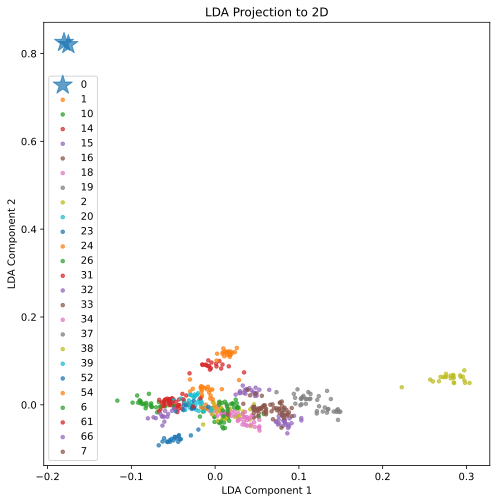

->Visualiza test data for 2 dimensions...


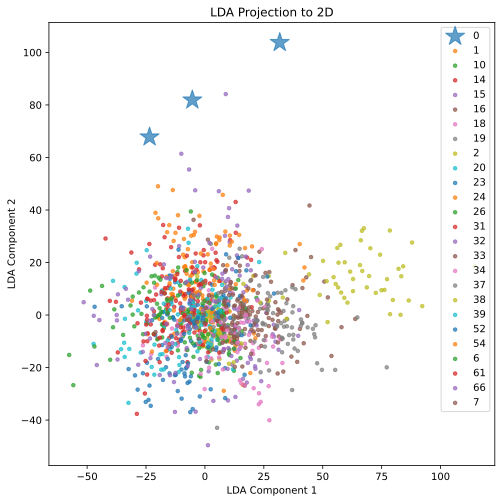

PIE Test Accuracy for 2 LDA dimensions: 7.54%
My Face (Label '0') Accuracy for 2 LDA dimensions: 100.00%
->Running LDA for 3 dimensions...
->Visualiza train data for 3 dimensions...


<Figure size 800x800 with 0 Axes>

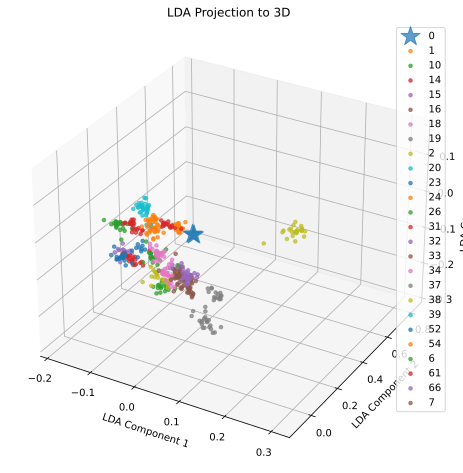

->Visualiza test data for 3 dimensions...


<Figure size 800x800 with 0 Axes>

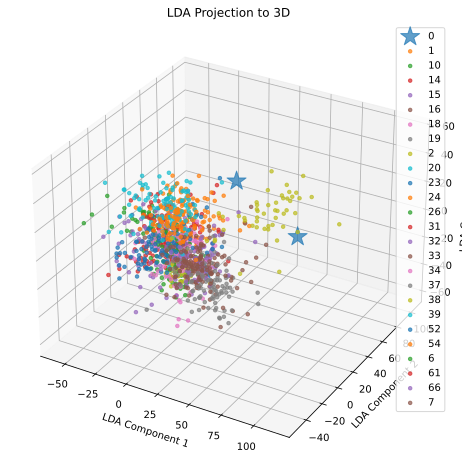

PIE Test Accuracy for 3 LDA dimensions: 12.17%
My Face (Label '0') Accuracy for 3 LDA dimensions: 100.00%
->Running LDA for 9 dimensions...
PIE Test Accuracy for 9 LDA dimensions: 43.88%
My Face (Label '0') Accuracy for 9 LDA dimensions: 100.00%


################# Use ALL the training data for LDA: #################
->Running LDA for 2 dimensions...
->Visualiza train data for 2 dimensions...


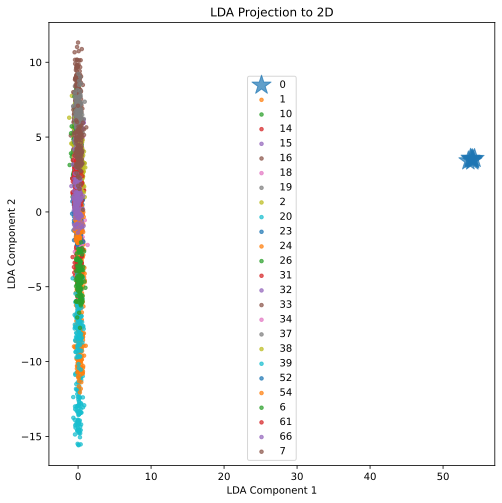

->Visualiza test data for 2 dimensions...


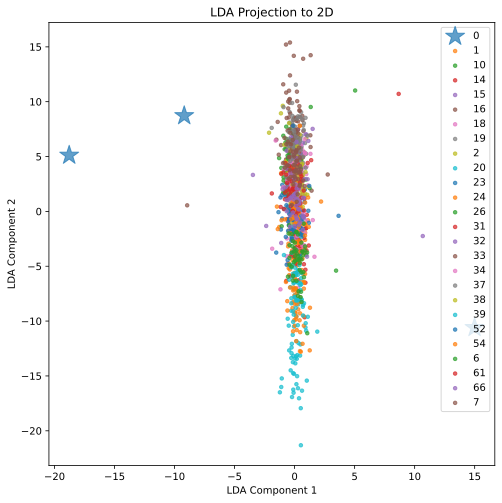

PIE Test Accuracy for 2 LDA dimensions: 19.47%
My Face (Label '0') Accuracy for 2 LDA dimensions: 0.00%
->Running LDA for 3 dimensions...
->Visualiza train data for 3 dimensions...


<Figure size 800x800 with 0 Axes>

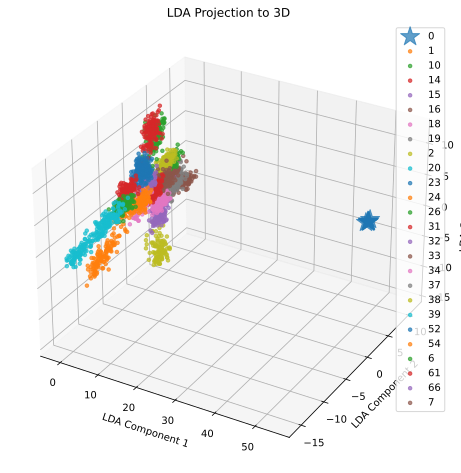

->Visualiza test data for 3 dimensions...


<Figure size 800x800 with 0 Axes>

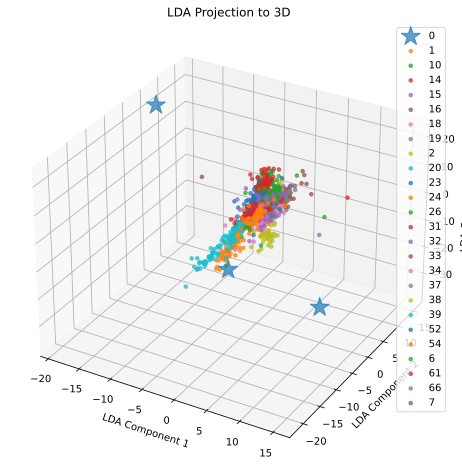

PIE Test Accuracy for 3 LDA dimensions: 45.13%
My Face (Label '0') Accuracy for 3 LDA dimensions: 0.00%
->Running LDA for 9 dimensions...
PIE Test Accuracy for 9 LDA dimensions: 91.60%
My Face (Label '0') Accuracy for 9 LDA dimensions: 0.00%


In [11]:
# configure the train data: 500 training samples
run_lda_processing(train_images,train_labels,test_images,test_labels)

print(f"\n\n################# Use ALL the training data for LDA: #################")
run_lda_processing(TRAIN_IMG,TRAIN_LABEL,test_images,test_labels)

#### @ LDA-Based Data Distribution Visualization Plus Nearest Neighbor Classification Results
##### Results:
* The distributions of training data and testing data are shown individually:
  * For training dataset, LDA showed better class separation compared to PCA, because it leverage the label information. Self-captured photos formed a cluster separate from CMU PIE data. 
  * Althought the results of training data are good for KNN classifier (based on euclidean distance), there is no guarantee a good performance in testing data. We can see some of the self-captured data points are projected nearby the PIE data points. Some are even projected to the opposite direction to the previous training self-captured data, causing the extremely low accuracy (0%) even when we use all the training data and increse the dimensionality.
* For PIE data, the increased dimension brings more distinguishing disturbution between each class, leading to the increasing accuracy of classification.
* For self-captured data, we can not guarantee the 7 training images are representative enough to gain good feature extraction, so the accuracy is low.
##### Analysis:
* LDA finds most discriminative projection by maximizing between-class distance and minimizing within-class distance, so in the training data, we can see points of same class are clustered and separated from other classes.
* The outcome shows that the results of the test data do not align with the training data can be explained as follows:
  * The number of samples is not large enough and training data not representative for each class, and in this case, PCA outdoes LDA.

## PART 3: SVM

### Step 1: data preparation

In [12]:
# prepare the data and labels (using all the training data!)
SVM_train_img = TRAIN_IMG
SVM_train_label = TRAIN_LABEL
SVM_test_img = test_images
SVM_test_label = test_labels
# run 80-D and 200-D pca to get data
X_train_pca_80, X_test_pca_80, pca_n_PC_80 = apply_pca(SVM_train_img, SVM_test_img, n_components=80)
X_train_pca_200, X_test_pca_200, pca_n_PC_200 = apply_pca(SVM_train_img, SVM_test_img, n_components=200)
# label should be real number
SVM_train_label = [int(label) for label in SVM_train_label]
SVM_test_label= [int(label) for label in SVM_test_label]

### Step 2: SVM classification (using LIBSVM)

In [13]:
from libsvm.svmutil import *
import numpy as np

def run_svm(X_train, y_train, X_test, y_test, C_values):
    """
    Run SVM classification with different values of C.
    Parameters:
    - X_train, y_train: Training data and labels.
    - X_test, y_test: Test data and labels.
    - C_values: List of penalty parameter C values.
    Returns:
    - results: A dictionary with C values as keys and accuracy as values.
    """
    results = {}
    for C in C_values:
        print(f"Training SVM with C={C}...")
        
        # Prepare data for libsvm
        problem = svm_problem(y_train, X_train)
        param = svm_parameter(f'-t 0 -c {C} -q')  # Linear kernel (-t 0), quiet mode (-q)
        
        # Train the model
        model = svm_train(problem, param)

        # Predict on test data
        _, accuracy, _ = svm_predict(y_test, X_test, model)
        print(f"Accuracy with C={C}: {accuracy[0]:.2f}%")
        
        # Store the accuracy
        results[C] = accuracy[0]  # accuracy[0] gives the overall accuracy

    return results

C_values = [1e-2, 1e-1, 1]
results_raw = run_svm(SVM_train_img, SVM_train_label, SVM_test_img, SVM_test_label, C_values)    #raw data: train_images, train_labels, test_images, test_labels
print(f"->Raw Image Results: {results_raw}\n\n")
results_pca80 = run_svm(X_train_pca_80, SVM_train_label, X_test_pca_80, SVM_test_label, C_values) # pca 80-dim data
print(f"->PCA 80 Results: {results_pca80}\n\n")
results_pca200 = run_svm(X_train_pca_200, SVM_train_label, X_test_pca_200, SVM_test_label, C_values) # pca 200-dim data
print(f"->PCA 200 Results: {results_pca200}\n\n")

Training SVM with C=0.01...
Accuracy = 99.4518% (1270/1277) (classification)
Accuracy with C=0.01: 99.45%
Training SVM with C=0.1...
Accuracy = 99.4518% (1270/1277) (classification)
Accuracy with C=0.1: 99.45%
Training SVM with C=1...
Accuracy = 99.4518% (1270/1277) (classification)
Accuracy with C=1: 99.45%
->Raw Image Results: {0.01: 99.45184025058731, 0.1: 99.45184025058731, 1: 99.45184025058731}


Training SVM with C=0.01...
Accuracy = 98.7471% (1261/1277) (classification)
Accuracy with C=0.01: 98.75%
Training SVM with C=0.1...
Accuracy = 98.7471% (1261/1277) (classification)
Accuracy with C=0.1: 98.75%
Training SVM with C=1...
Accuracy = 98.7471% (1261/1277) (classification)
Accuracy with C=1: 98.75%
->PCA 80 Results: {0.01: 98.74706342991387, 0.1: 98.74706342991387, 1: 98.74706342991387}


Training SVM with C=0.01...
Accuracy = 99.3735% (1269/1277) (classification)
Accuracy with C=0.01: 99.37%
Training SVM with C=0.1...
Accuracy = 99.3735% (1269/1277) (classification)
Accuracy wi

#### @ SVM Classification Results with Different Parameter Values
##### Results:
The SVM classification results demonstrate excellent performance for both raw data and PCA dimension-reduced data.
1. Accuracies for C=1e-2, 1e-1, 1 are the same.
2. Accuracies for raw image, PCA 80-Dimemsion images and PCA 200-Dimemsion are similar to each other.
##### Analysis:
1. For 1: Indicating that all the feature sets provide the good separability for the linear SVM, so the larger parameter C for relaxing the constraints (allow a few misclassified samples) does not bring a better result.
2. For 2: Similarly, the original data is already seperable for linear SVM, as we reduce the dimension, the accuracy slightly decreased to 99.37% and 98.75%.

## PART 4: CNN

#### Step 1: data preparation

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# 定义数据预处理步骤
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 转为灰度图
    transforms.Resize((32, 32)),  # 调整图像大小
    transforms.ToTensor(),  # 转为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化
])

# 加载训练集和测试集
train_dataset = ImageFolder(root=TRAIN_DIR, transform=transform)
test_dataset = ImageFolder(root=TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Step 2: CNN (using pytorch)

Output shape: torch.Size([1, 26])
Epoch 1/10, Loss: 2.5118
Epoch 2/10, Loss: 0.5833
Epoch 3/10, Loss: 0.3047
Epoch 4/10, Loss: 0.1139
Epoch 5/10, Loss: 0.0678
Epoch 6/10, Loss: 0.0622
Epoch 7/10, Loss: 0.0411
Epoch 8/10, Loss: 0.0114
Epoch 9/10, Loss: 0.0432
Epoch 10/10, Loss: 0.0065


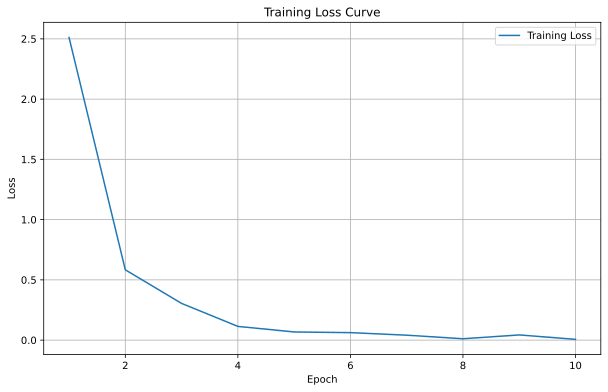

Overall Accuracy: 98.12%
PIE Accuracy: 98.12%
My Face Accuracy: 100.00%


In [15]:
# define the CNN model (number of nodes: 20-50-500-26)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(50 * 8 * 8, 500)  # flatten to 50x8x8
        self.fc2 = nn.Linear(500, 26)  # output 26 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # the 1st conv layer + activation + pooling
        x = self.pool(torch.relu(self.conv2(x))) # the 2nd conv layer + activation + pooling
        x = x.view(-1, 50 * 8 * 8)  # flattern
        x = torch.relu(self.fc1(x)) # the 1st fully connected layer
        x = self.fc2(x)             # the 2nd fully connected layer
        return x

# create a CNN model, define a loss function, and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# check the parameters of the CNN model
dummy_input = torch.randn(1, 1, 32, 32)
output = model(dummy_input)
print("Output shape:", output.shape)


# train the CNN model
train_losses = [] # to store the losses

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# plot the loss curve    
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()

# test the CNN model
model.eval()

# to compute accuracy
correct = 0
total = 0
pie_correct = 0
pie_total = 0
my_face_correct = 0
my_face_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # overall
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # PIE
        pie_mask = (labels != 0)
        pie_correct += (predicted[pie_mask] == labels[pie_mask]).sum().item()
        pie_total += pie_mask.sum().item()

        # my face
        my_face_mask = (labels == 0)
        my_face_correct += (predicted[my_face_mask] == labels[my_face_mask]).sum().item()
        my_face_total += my_face_mask.sum().item()

accuracy = correct / total
pie_accuracy = pie_correct / pie_total if pie_total > 0 else 0
my_face_accuracy = my_face_correct / my_face_total if my_face_total > 0 else 0

print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"PIE Accuracy: {pie_accuracy * 100:.2f}%")
print(f"My Face Accuracy: {my_face_accuracy * 100:.2f}%")

#### @ CNN Classification Results
##### Results:
* The loss curve rapidly decreases at the beginning, and gradually drops to 0.0065.
* CNN outperformed all other methods and achieved 98.12% and 100% respectively in PIE data and self-captured data.
* Self-captured photos achieved perfect accuracy, likely due to the model’s ability to learn specific features.
##### Analysis:
* CNN outperformed all other methods, leveraging hierarchical feature extraction through the convolutional layers. CNN’s convolutional layers extract low-level features (e.g., edges, textures) in the initial layers and gradually build higher-level, more abstract features in the deeper layers (e.g., facial structures). These hierarchical features are more representative of the input data compared to global features like those extracted by PCA or LDA.
* Unlike PCA or LDA, CNN can learn these patterns directly from the data.
* CNNs learn features and classification simultaneously: In methods like PCA or LDA, dimensionality reduction is performed first, followed by classification using another model (e.g., KNN or SVM). These steps are independent and may not optimize for overall classification performance. CNNs, however, jointly optimize feature extraction and classification during training, leading to better integration of features for the classification task.